In [1]:
pip install pandas scikit-learn openpyxl matplotlib seaborn numpy==1.26.0

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
print(np.__version__)

1.26.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка данных
train_path = "train.xlsx"
test_path = "test.xlsx"

train = pd.read_excel(train_path)
test = pd.read_excel(test_path)


In [4]:
# 2. Базовый анализ данных
def analyze_data(df, name="Dataset"):
    print(f"\n{name} Info:\n")
    print(df.info())
    print("\nMissing values:\n", df.isnull().sum())
    print("\nBasic Statistics:\n", df.describe())
    print("\nFirst few rows:\n", df.head())

analyze_data(train, "Train Data")
analyze_data(test, "Test Data")



Train Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None

Missing values:
 dt                  0
Цена на арматуру    0
dtype: int64

Basic Statistics:
                         dt  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-29 18:00:00      42000.000000
max    2022-08-29 00:00:00      79000.000000
std                    NaN      13407.979668

First few rows:
           dt  Цена на арматуру
0 2015-01-05             32900
1 2015-01-12       

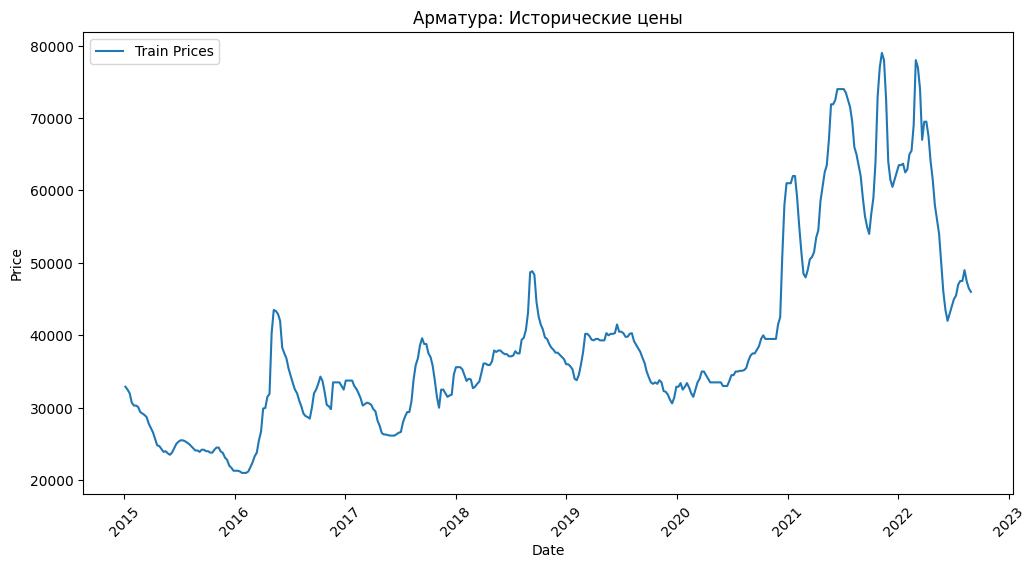

In [5]:
# 3. Визуализация временного ряда цен
plt.figure(figsize=(12, 6))
sns.lineplot(x=train["dt"], y=train["Цена на арматуру"], label="Train Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Арматура: Исторические цены")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 4. Добавление новых признаков
def feature_engineering(df):
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["week"] = df["dt"].dt.isocalendar().week
    df["day_of_week"] = df["dt"].dt.dayofweek
    return df


train = feature_engineering(train)
test = feature_engineering(test)


In [37]:
# Функция для добавления лагов и скользящих средних
def add_lags_and_rolling_features(df, lags=[1, 2, 3, 4], roll_windows=[2, 4]):
    df = df.copy()
    
    # Добавляем лаги (цены прошлых недель)
    for lag in lags:
        df[f'price_lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
    # Добавляем скользящие средние (усредненные цены за несколько недель)
    for window in roll_windows:
        df[f'price_roll_mean_{window}'] = df['Цена на арматуру'].rolling(window=window).mean()
    
    return df

# Добавляем признаки к processed_train и processed_test
train = add_lags_and_rolling_features(train)
test = add_lags_and_rolling_features(test)

In [38]:
# 5. Сохранение обработанных данных
train.to_csv("processed_train.csv", index=False)
test.to_csv("processed_test.csv", index=False)

print("Предобработка завершена. Данные сохранены.")


Предобработка завершена. Данные сохранены.


In [8]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit

# Функция для генерации лагов и скользящих средних
def create_features(df, lag_weeks=[1, 2, 3, 4], rolling_weeks=[2, 4]):
    df = df.copy()
    for lag in lag_weeks:
        df[f'price_lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    for window in rolling_weeks:
        df[f'price_roll_mean_{window}'] = df['Цена на арматуру'].shift(1).rolling(window).mean()
    df.dropna(inplace=True)  # Убираем строки с NaN (из-за лагов)
    return df

# Загрузка данных
data = pd.read_csv("processed_test.csv", parse_dates=["dt"])
data = data.sort_values("dt")  # Временной порядок важен!
data = create_features(data)

# Разделяем признаки и целевую переменную
X = data.drop(columns=["dt", "Цена на арматуру"])
y = data["Цена на арматуру"]

# Кросс-валидация по времени
ts_cv = TimeSeriesSplit(n_splits=5)

# Обучение модели с лучшими параметрами
model = CatBoostRegressor(
    iterations=2000,         
    depth=7,                 
    learning_rate=0.03,      
    l2_leaf_reg=10,          
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    early_stopping_rounds=100
)

# Обучение с кросс-валидацией
for train_idx, test_idx in ts_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)
    model.fit(train_pool, eval_set=test_pool)

# Прогноз на тестовой выборке
test["predicted_price"] = model.predict(test[X.columns])

# Генерация рекомендации по тендеру
test["recommended_weeks"] = np.where(
    test["predicted_price"] > test["predicted_price"].shift(1), 6, 1
)

# Вывод результатов
print(test[["predicted_price", "recommended_weeks"]].head())


0:	learn: 848.7499998	test: 2844.9999997	best: 2844.9999997 (0)	total: 799us	remaining: 1.6s
1:	learn: 826.9250003	test: 2815.9000003	best: 2815.9000003 (1)	total: 1.18ms	remaining: 1.18s
2:	learn: 812.8115000	test: 2787.6730002	best: 2787.6730002 (2)	total: 1.4ms	remaining: 934ms
3:	learn: 788.4271562	test: 2760.2928116	best: 2760.2928116 (3)	total: 1.73ms	remaining: 865ms
4:	learn: 761.8683732	test: 2733.7340286	best: 2733.7340286 (4)	total: 1.95ms	remaining: 777ms
5:	learn: 745.4466668	test: 2707.9720090	best: 2707.9720090 (5)	total: 2.21ms	remaining: 736ms
6:	learn: 723.0832675	test: 2682.9828500	best: 2682.9828500 (6)	total: 2.52ms	remaining: 719ms
7:	learn: 701.3907698	test: 2658.7433650	best: 2658.7433650 (7)	total: 2.85ms	remaining: 709ms
8:	learn: 689.0781594	test: 2635.2310652	best: 2635.2310652 (8)	total: 3.04ms	remaining: 673ms
9:	learn: 671.4444450	test: 2612.4241333	best: 2612.4241333 (9)	total: 3.3ms	remaining: 657ms
10:	learn: 651.3011120	test: 2590.3014098	best: 2590.3

In [43]:
pip install pmdarima statsmodels



  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/613.3 kB ? eta -:--:--
   ---------------------------------------- 613.3/613.3 kB 7.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------- ----------- 7.1/9.8 MB 33.6 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 29.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 23.1 MB/s eta 0:00:00
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached urllib3-2.3.0-py3-none-any.whl (128 kB)


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error

# Загружаем данные
train = pd.read_csv("processed_train.csv", parse_dates=["dt"])
test = pd.read_csv("processed_test.csv", parse_dates=["dt"])

# Устанавливаем дату как индекс
train.set_index("dt", inplace=True)
test.set_index("dt", inplace=True)

# Оставляем только колонку с ценой
train_series = train["Цена на арматуру"]
test_series = test["Цена на арматуру"]

# Автоматический подбор параметров модели
auto_model = auto_arima(train_series, seasonal=True, m=52, trace=True, stepwise=True)
auto_model.summary()

# Обучение модели с найденными параметрами
sarima_model = SARIMAX(train_series, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
sarima_result = sarima_model.fit()

# Прогноз на тестовый период
sarima_forecast = sarima_result.predict(start=test_series.index[0], end=test_series.index[-1])




c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: F

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=6982.494, Time=7.12 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=7071.045, Time=0.03 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=6979.905, Time=3.10 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=6994.544, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=7069.196, Time=0.03 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=6979.766, Time=0.18 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=6981.338, Time=1.31 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=6983.063, Time=2.43 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=6983.305, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=6983.192, Time=0.10 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=6995.711, Time=0.08 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=6981.320, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[52]             : AIC=6977.770, Time=0.09 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[52]             : AIC=6977.905, Time=1.15 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[52]             : AIC=6979.312, Time=0.95 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[52]             : AIC=6981.048, Time=2.10 sec
 ARIMA(2,1,0)(0,0,0)[52]             : AIC=6981.217, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[52]             : AIC=6981.082, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=6993.705, Time=0.05 sec


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[52]             : AIC=6979.257, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[52]          
Total fit time: 20.741 seconds


c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\jacke\OneDrive\Рабочий стол\intens3\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


MAE SARIMA: 3052.29371671096


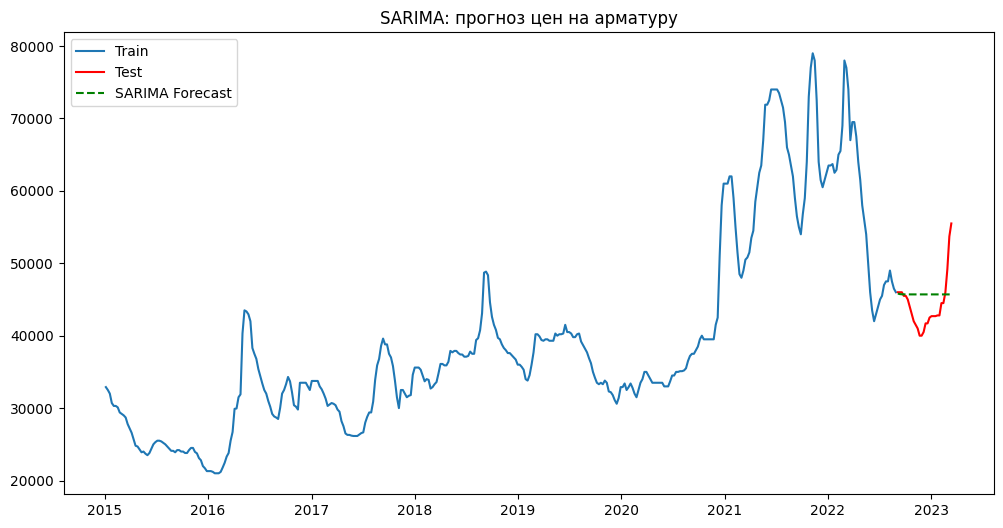

In [46]:
mae_sarima = mean_absolute_error(test_series, sarima_forecast)
print(f"MAE SARIMA: {mae_sarima}")

# Визуализация прогноза
plt.figure(figsize=(12,6))
plt.plot(train_series, label="Train")
plt.plot(test_series, label="Test", color="red")
plt.plot(sarima_forecast, label="SARIMA Forecast", linestyle="dashed", color="green")
plt.legend()
plt.title("SARIMA: прогноз цен на арматуру")
plt.show()
